# 📚 Week 7.1: Tree-Based Ensemble Methods for Finance

---

## 🎯 Learning Objectives

This week covers **tree-based ensemble methods** for trading:

| Day | Topic | Key Concepts |
|-----|-------|--------------|
| 1 | Decision Trees | Splitting, pruning, Gini/entropy |
| 2 | Random Forest | Bagging, feature importance |
| 3 | XGBoost | Gradient boosting, regularization |
| 4 | LightGBM | Leaf-wise growth, efficiency |
| 5 | CatBoost | Categorical features, ordered boosting |
| 6 | Ensemble Stacking | Model combination |
| 7 | Interview Review | Practice questions |

---

In [1]:
# ============================================================
# IMPORTS & DATA
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Sample data
ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=756)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
returns = data['Close'].pct_change().dropna()
print(f"✅ Loaded {len(returns)} trading days")

📥 Downloading data...
✅ Loaded 516 trading days


---

# 📊 Day 1: Decision Trees

## Theory

### Splitting Criteria

**Gini Impurity:**
$$Gini = 1 - \sum_{k=1}^{K} p_k^2$$

**Entropy (Information Gain):**
$$Entropy = -\sum_{k=1}^{K} p_k \log_2(p_k)$$

### Information Gain

$$IG = Entropy(parent) - \sum_{j} \frac{n_j}{n} Entropy(child_j)$$

### Tree Depth
- **Shallow trees:** High bias, low variance (underfitting)
- **Deep trees:** Low bias, high variance (overfitting)

### Financial Application
- Interpretable decision rules
- Non-linear relationships
- Feature interactions

---

📊 DECISION TREE DEPTH COMPARISON
Depth   2: Train=0.610, Test=0.572
Depth   4: Train=0.658, Test=0.553
Depth   6: Train=0.701, Test=0.546
Depth   8: Train=0.771, Test=0.586
Depth   ∞: Train=1.000, Test=0.513


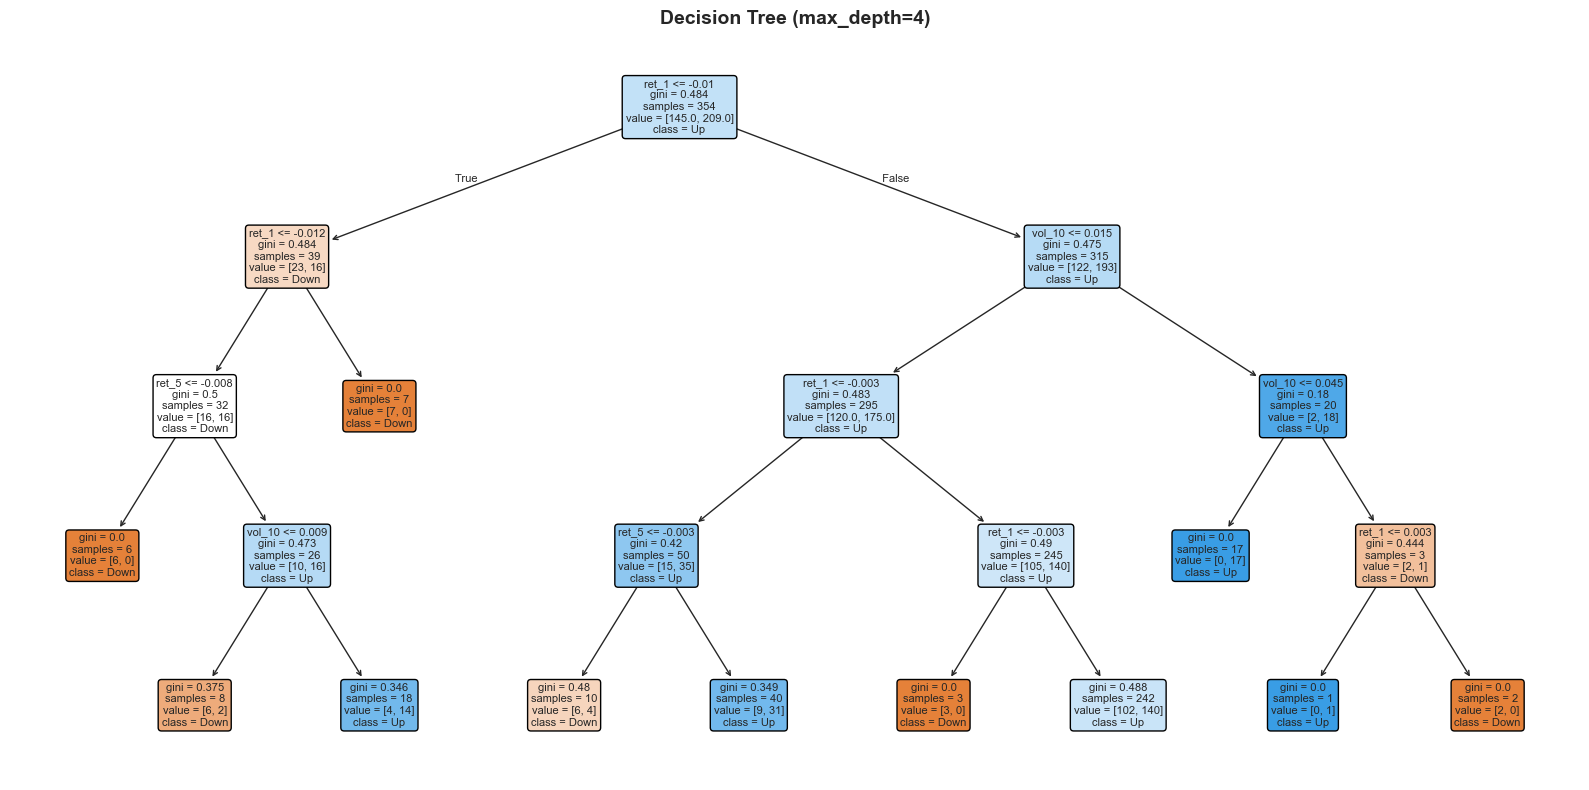

In [2]:
# ============================================================
# DAY 1: DECISION TREES
# ============================================================

# Create features
df = pd.DataFrame(index=returns.index)
df['ret_1'] = returns.shift(1)
df['ret_5'] = returns.shift(1).rolling(5).mean()
df['vol_10'] = returns.rolling(10).std().shift(1)
df['momentum'] = data['Close'].pct_change(10).shift(1)
df['label'] = (returns.shift(-1) > 0).astype(int)
df = df.dropna()

X = df[['ret_1', 'ret_5', 'vol_10', 'momentum']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Decision Trees with different depths
print("📊 DECISION TREE DEPTH COMPARISON")
print("=" * 60)

depths = [2, 4, 6, 8, None]
for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    train_acc = tree.score(X_train, y_train)
    test_acc = tree.score(X_test, y_test)
    
    depth_str = str(depth) if depth else "∞"
    print(f"Depth {depth_str:>3}: Train={train_acc:.3f}, Test={test_acc:.3f}")

# Visualize best tree
best_tree = DecisionTreeClassifier(max_depth=4, random_state=42)
best_tree.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(16, 8))
plot_tree(best_tree, feature_names=X.columns, class_names=['Down', 'Up'],
          filled=True, rounded=True, ax=ax, fontsize=8)
ax.set_title('Decision Tree (max_depth=4)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

# 📊 Day 2: Random Forest

## Theory

### Bagging (Bootstrap Aggregating)
1. Create B bootstrap samples from training data
2. Train a tree on each sample
3. Average predictions (regression) or vote (classification)

$$\hat{f}_{bag}(x) = \frac{1}{B}\sum_{b=1}^{B}\hat{f}^b(x)$$

### Key Hyperparameters
- **n_estimators:** Number of trees (more = better, but diminishing returns)
- **max_features:** Features to consider at each split (sqrt for classification)
- **max_depth:** Depth of each tree

### Out-of-Bag (OOB) Error
- Each bootstrap sample uses ~63% of data
- Remaining 37% used for OOB estimation (free validation!)

### Feature Importance
- **Mean Decrease Impurity (MDI):** Gini importance
- **Mean Decrease Accuracy (MDA):** Permutation importance

---

📊 RANDOM FOREST RESULTS
Train Accuracy: 0.816
Test Accuracy: 0.592
OOB Score: False

Feature Importance (MDI):
   vol_10: 0.270
   momentum: 0.245
   ret_5: 0.243
   ret_1: 0.242


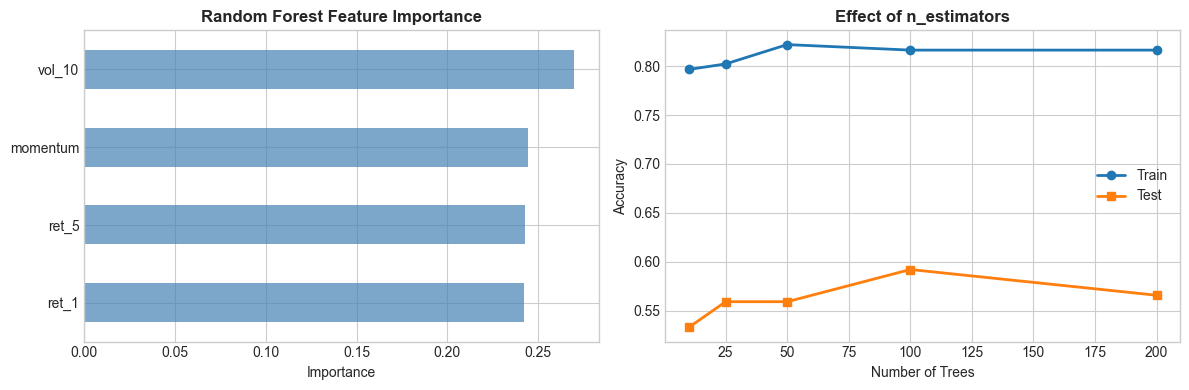

In [3]:
# ============================================================
# DAY 2: RANDOM FOREST
# ============================================================

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf.fit(X_train, y_train)

print("📊 RANDOM FOREST RESULTS")
print("=" * 60)
print(f"Train Accuracy: {rf.score(X_train, y_train):.3f}")
print(f"Test Accuracy: {rf.score(X_test, y_test):.3f}")
print(f"OOB Score: {rf.oob_score if hasattr(rf, 'oob_score') else 'N/A'}")

# Feature Importance
print("\nFeature Importance (MDI):")
importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
for feat, imp in importance.items():
    print(f"   {feat}: {imp:.3f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Feature importance
ax1 = axes[0]
importance.sort_values().plot(kind='barh', ax=ax1, color='steelblue', alpha=0.7)
ax1.set_xlabel('Importance')
ax1.set_title('Random Forest Feature Importance', fontweight='bold')

# n_estimators effect
ax2 = axes[1]
n_trees_range = [10, 25, 50, 100, 200]
train_scores = []
test_scores = []
for n in n_trees_range:
    rf_temp = RandomForestClassifier(n_estimators=n, max_depth=6, random_state=42)
    rf_temp.fit(X_train, y_train)
    train_scores.append(rf_temp.score(X_train, y_train))
    test_scores.append(rf_temp.score(X_test, y_test))

ax2.plot(n_trees_range, train_scores, 'o-', label='Train', linewidth=2)
ax2.plot(n_trees_range, test_scores, 's-', label='Test', linewidth=2)
ax2.set_xlabel('Number of Trees')
ax2.set_ylabel('Accuracy')
ax2.set_title('Effect of n_estimators', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

---

# 📊 Day 3: XGBoost

## Theory

### Gradient Boosting
Sequential tree building to minimize loss:

$$\hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + \eta \cdot f_t(x_i)$$

### XGBoost Objective

$$\mathcal{L} = \sum_{i} l(y_i, \hat{y}_i) + \sum_{k}\Omega(f_k)$$

**Regularization term:**
$$\Omega(f) = \gamma T + \frac{1}{2}\lambda ||w||^2$$

- **T:** Number of leaves
- **w:** Leaf weights
- **γ, λ:** Regularization parameters

### Key Parameters
- **learning_rate (eta):** Step size shrinkage
- **max_depth:** Tree depth
- **subsample:** Row sampling
- **colsample_bytree:** Feature sampling

---

📊 XGBOOST RESULTS
Train Accuracy: 0.944
Test Accuracy: 0.526

Feature Importance:
   ret_5: 0.262
   vol_10: 0.258
   ret_1: 0.240
   momentum: 0.240


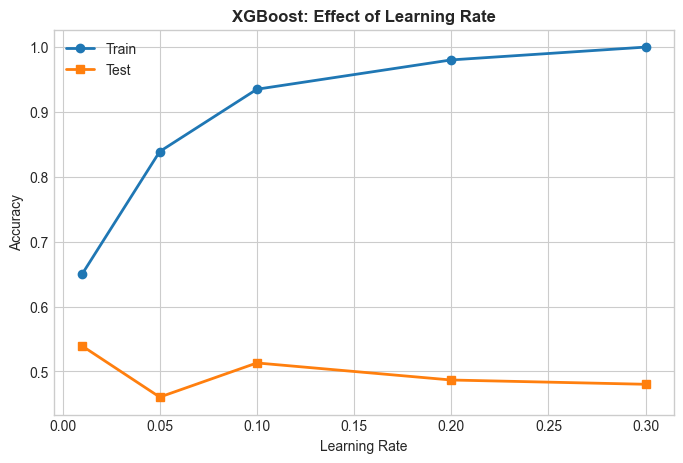

In [4]:
# ============================================================
# DAY 3: XGBOOST
# ============================================================
try:
    import xgboost as xgb
    
    # XGBoost model
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    
    xgb_model.fit(X_train, y_train)
    
    print("📊 XGBOOST RESULTS")
    print("=" * 60)
    print(f"Train Accuracy: {xgb_model.score(X_train, y_train):.3f}")
    print(f"Test Accuracy: {xgb_model.score(X_test, y_test):.3f}")
    
    # Feature importance
    print("\nFeature Importance:")
    xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    for feat, imp in xgb_importance.items():
        print(f"   {feat}: {imp:.3f}")
    
    # Learning rate comparison
    fig, ax = plt.subplots(figsize=(8, 5))
    lr_range = [0.01, 0.05, 0.1, 0.2, 0.3]
    train_lr = []
    test_lr = []
    for lr in lr_range:
        model = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=lr, 
                                   random_state=42, use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train, y_train)
        train_lr.append(model.score(X_train, y_train))
        test_lr.append(model.score(X_test, y_test))
    
    ax.plot(lr_range, train_lr, 'o-', label='Train', linewidth=2)
    ax.plot(lr_range, test_lr, 's-', label='Test', linewidth=2)
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Accuracy')
    ax.set_title('XGBoost: Effect of Learning Rate', fontweight='bold')
    ax.legend()
    plt.show()
    
except ImportError:
    print("⚠️ XGBoost not installed. Using GradientBoosting from sklearn.")
    gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
    gb_model.fit(X_train, y_train)
    print(f"Train Accuracy: {gb_model.score(X_train, y_train):.3f}")
    print(f"Test Accuracy: {gb_model.score(X_test, y_test):.3f}")

---

# 📊 Day 4: LightGBM

## Theory

### Key Differences from XGBoost
1. **Leaf-wise Growth:** Chooses leaf with max delta loss (vs. level-wise)
2. **Histogram-based:** Bins continuous features
3. **GOSS:** Gradient-based One-Side Sampling
4. **EFB:** Exclusive Feature Bundling

### Advantages
- Faster training (especially large datasets)
- Lower memory usage
- Often better accuracy on large data

### Key Parameters
- **num_leaves:** Control complexity (higher = more complex)
- **min_data_in_leaf:** Minimum samples in leaf
- **feature_fraction:** Column sampling

---

In [5]:
# ============================================================
# DAY 4: LIGHTGBM
# ============================================================
try:
    import lightgbm as lgb
    
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100,
        num_leaves=31,
        max_depth=-1,
        learning_rate=0.1,
        random_state=42,
        verbose=-1
    )
    
    lgb_model.fit(X_train, y_train)
    
    print("📊 LIGHTGBM RESULTS")
    print("=" * 60)
    print(f"Train Accuracy: {lgb_model.score(X_train, y_train):.3f}")
    print(f"Test Accuracy: {lgb_model.score(X_test, y_test):.3f}")
    
    # Feature importance
    lgb_importance = pd.Series(lgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print("\nFeature Importance:")
    for feat, imp in lgb_importance.items():
        print(f"   {feat}: {imp}")
    
except ImportError:
    print("⚠️ LightGBM not installed. Skipping...")

📊 LIGHTGBM RESULTS
Train Accuracy: 0.972
Test Accuracy: 0.493

Feature Importance:
   ret_5: 353
   vol_10: 347
   ret_1: 339
   momentum: 277


---

# 📊 Day 5: CatBoost

## Theory

### Key Features
1. **Ordered Boosting:** Prevents prediction shift (target leakage)
2. **Categorical Handling:** Native support for categorical features
3. **Symmetric Trees:** Faster inference

### Ordered Target Statistics
For categorical feature processing:
$$\hat{x}_k^i = \frac{\sum_{j=1}^{i-1}[x_j^{(k)} = x_i^{(k)}] \cdot y_j + a \cdot p}{\sum_{j=1}^{i-1}[x_j^{(k)} = x_i^{(k)}] + a}$$

### Use Cases
- Data with many categorical features
- When preventing overfitting is critical
- Small datasets

---

In [6]:
# ============================================================
# DAY 5: CATBOOST
# ============================================================
try:
    from catboost import CatBoostClassifier
    
    cat_model = CatBoostClassifier(
        iterations=100,
        depth=4,
        learning_rate=0.1,
        random_state=42,
        verbose=0
    )
    
    cat_model.fit(X_train, y_train)
    
    print("📊 CATBOOST RESULTS")
    print("=" * 60)
    print(f"Train Accuracy: {cat_model.score(X_train, y_train):.3f}")
    print(f"Test Accuracy: {cat_model.score(X_test, y_test):.3f}")
    
except ImportError:
    print("⚠️ CatBoost not installed. Skipping...")

⚠️ CatBoost not installed. Skipping...


---

# 📊 Day 6: Ensemble Stacking

## Theory

### Stacking Architecture
1. **Level 0:** Base models (diverse learners)
2. **Level 1:** Meta-learner (combines base predictions)

### Key Principles
- **Diversity:** Base models should be different
- **Avoid Overfitting:** Use out-of-fold predictions
- **Meta-learner:** Often simple (Logistic, Linear)

### Implementation
1. Train base models on training data
2. Get out-of-fold predictions
3. Train meta-learner on out-of-fold predictions
4. Final prediction: meta-learner(base_predictions)

---

In [7]:
# ============================================================
# DAY 6: ENSEMBLE STACKING
# ============================================================
from sklearn.ensemble import StackingClassifier

# Base models
base_models = [
    ('dt', DecisionTreeClassifier(max_depth=4, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=50, max_depth=4, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, max_depth=4, random_state=42))
]

# Stacking ensemble
stack = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=5
)

from sklearn.linear_model import LogisticRegression
stack = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=5
)

stack.fit(X_train, y_train)

print("📊 STACKING ENSEMBLE RESULTS")
print("=" * 60)
print(f"Train Accuracy: {stack.score(X_train, y_train):.3f}")
print(f"Test Accuracy: {stack.score(X_test, y_test):.3f}")

# Compare all models
print("\n📊 MODEL COMPARISON:")
models_compare = {
    'Decision Tree': best_tree,
    'Random Forest': rf,
    'Stacking': stack
}

for name, model in models_compare.items():
    test_acc = model.score(X_test, y_test)
    print(f"   {name}: {test_acc:.3f}")

NameError: name 'LogisticRegression' is not defined

---

# 📊 Day 7: Interview Review

## Common Interview Questions

### Q1: Explain the difference between bagging and boosting.
**Answer:**
- **Bagging:** Parallel training on bootstrap samples, reduces variance
- **Boosting:** Sequential training to fix errors, reduces bias

### Q2: Why is Random Forest less prone to overfitting than a single tree?
**Answer:**
- Averages many trees → reduces variance
- Feature subsampling → decorrelates trees
- Bootstrap samples → different perspectives

### Q3: What is the advantage of XGBoost over traditional gradient boosting?
**Answer:**
- Regularization (L1, L2 on leaf weights)
- Parallel processing
- Built-in handling of missing values
- Tree pruning

### Q4: When to use LightGBM vs XGBoost?
**Answer:**
- **LightGBM:** Large datasets, faster training needed
- **XGBoost:** Smaller datasets, more control

---

## Summary Table

| Model | Pros | Cons | Best For |
|-------|------|------|----------|
| Decision Tree | Interpretable | Overfits | Baseline, rules |
| Random Forest | Robust, parallel | Memory | General purpose |
| XGBoost | High accuracy | Slow on large data | Structured data |
| LightGBM | Fast, efficient | May overfit | Large datasets |
| CatBoost | Categorical support | Slower | Many categoricals |
| Stacking | Best accuracy | Complex | Competitions |

---